# TRPO : Linear Programming Approach

In [602]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import scipy
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

In [603]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards = np.random.rand(self.num_action,self.num_state,self.num_state)

In [604]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

In [605]:
def evaluate_q(env, pi, gamma, V):
    Q = np.zeros((env.num_state,env.num_action))
    for s in env.states:
        for a in env.actions:
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            Q[s][a] = np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    return Q

In [606]:
def trpo_simplex(env,delta,gamma,EPS,rho,num_iterations):
    history = []
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    
    
    r = list(rho)
    r_1 = []
    for i in range(0,env.num_action):
        r_1 = r_1+r
    rho_1 = np.transpose(np.reshape(r_1,(env.num_action,env.num_state)))
    rho_1 = np.reshape(rho_1,(1,-1))[0]
    
    
    for i in range(num_iterations):
        V = evaluate_policy(env, pi, gamma, theta)
        Q_value = evaluate_q(env, pi, gamma, V)
        history.append(np.mean(V))
        
        Advantage = Q_value-V
        Advantage_vector = np.reshape(Advantage,(1,-1))[0]
       
        
        
        '''
        c
        '''
        x = np.multiply(rho_1,Advantage_vector)
        x = list(x) + list(np.zeros(env.num_state*env.num_action))
        c = -np.array(x)
        
        '''
        A_ub
        '''
        g_1 = [np.array(list(np.zeros(env.num_state*env.num_action)) + list(np.ones(env.num_state*env.num_action)))]
        
        g_21 = np.identity(env.num_state*env.num_action)
        g_22 = -np.identity(env.num_state*env.num_action)
        
        g_2 = list(np.concatenate((g_21,g_22),axis=1))
        
        g_31 = -np.identity(env.num_state*env.num_action)
        g_32 = -np.identity(env.num_state*env.num_action)
        
        g_3 = list(np.concatenate((g_31,g_32),axis=1))
        I = -np.identity(2*env.num_state*env.num_action)

        A_ub = np.concatenate((np.array(g_1+g_2+g_3),I),axis=0)
        
        '''
        b_ub
        '''
        pi_1 = np.reshape(pi,(1,-1))[0]
        b_ub = np.array([delta]+list(pi_1)+list(-pi_1)+list(np.zeros(2*env.num_state*env.num_action)))
        
        
        
        '''
        b_eq
        '''
        b_eq = np.ones(env.num_state)
        
        '''
        A_eq
        '''
        A = []
        I = np.identity(env.num_state*env.num_action)
        for s in env.states:
            x = 0
            for a in range(s*env.num_action,s*env.num_action+env.num_action):
                
                x += I[a]
            
            A.append(np.array(list(x)+list(np.zeros(env.num_state*env.num_action))))
        A_eq =  np.array(A) 
        
 
        res = scipy.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,method='simplex')
        pi = res['x'][:env.num_state*env.num_action]
        pi = np.reshape(pi,(env.num_state,env.num_action))
        
    return history


In [607]:

s=5
a=3
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R



In [608]:
gamma = 0.9
EPS = 0.0001
delta = 0.9
num_iterations=100
np.random.seed(0)
rho = np.random.rand(env.num_state)
rho = rho/np.sum(rho)

In [609]:
history = trpo_simplex(env,delta,gamma,EPS,rho,num_iterations)

In [610]:
V_optimal_policy,pi_optimal_policy=policy_iteration(env, gamma, EPS)



In [611]:
np.mean(V_optimal_policy)

6.932722263120631

In [612]:
history[-1]

6.932722263120631

In [613]:
def plot_log(history):
    
    y=history
    x=np.array(range(1,len(history)+1))
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('V_rho', fontsize=12)
    plt.plot(x,y,color='blue', label='TRPO_Simplex') 
    plt.title('100x3 MDP delta=0.9',fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

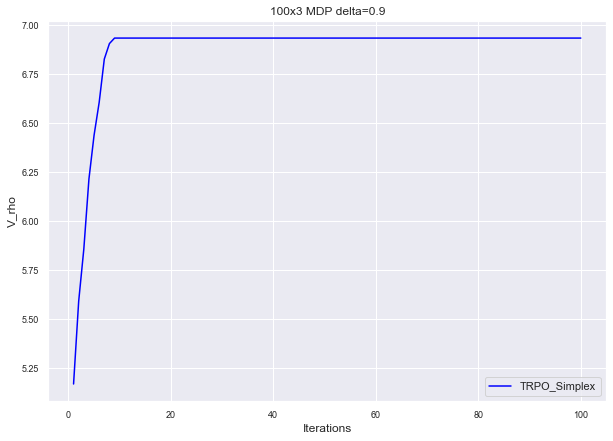

In [614]:
plot_log(history)